<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>03. Baseline OIL and GAS light gbm regressor</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Separación de OIL y GAS](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Entrenamiento del modelo OIL](#32)<br>
    3.2. [Evaluación del modelo OIL](#32)<br>
    3.2. [Entrenamiento del modelo GAS](#32)<br>
    3.2. [Evaluación del modelo GAS](#32)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

In [ ]:
# Esta función grafica los residuos de las predicciones del modelo
def diag_residuos (y, prediccion):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    residuos   = prediccion - y
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(y, prediccion, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
1051,Pozo 370-Pozo 42-5,Campo F,OIL,PAD-82,Pozo 370,5,Pozo 42,1000.717487,1000.403244,25.076654,24.849876,0.0,NO,14.6,0.0,Abierto
16231,Pozo 219-Pozo 213-24,Campo E,OIL,PAD-57,Pozo 219,24,Pozo 213,1386.897646,1386.895214,-2.597354,61.393064,1.0,NO,387.2,0.0,Abierto
15487,Pozo 477-Pozo 110-14,Campo C,GAS,PAD-17,Pozo 477,14,Pozo 110,552.609171,549.608168,57.513110,270.710132,0.0,NO,336.7,0.0,Abierto
9252,Pozo 131-Pozo 92-17,Campo C,GAS,PAD-25,Pozo 131,17,Pozo 92,1562.962610,1562.917308,11.899887,215.593482,0.0,NO,64.6,0.0,Abierto
17357,Pozo 315-Pozo 322-11,Campo E,OIL,PAD-72,Pozo 315,11,Pozo 322,439.365220,437.730931,37.860645,86.721016,1.0,NO,1.1,0.0,Cerrado


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="24"></a> <br>
### 2.4. Separación de OIL y GAS
**Se dividen en un dataframe las instancias correspondientes a OIL y en otro las correspondientes a GAS**

In [ ]:
# dataframe con instancias correspondientes a OIL
df_oil = df[df.FLUIDO == "OIL"]
print("Cantidad de intancias de OIL = ", df_oil.shape[0])

# dataframe con instancias correspondientes a GAS
df_gas = df[df.FLUIDO == "GAS"]
print("Cantidad de instancias de GAS = ", df_gas.shape[0])

Cantidad de intancias de OIL =  19974
Cantidad de instancias de GAS =  6204


<a id="25"></a> <br>
### 2.5. Separación en train y test

**Train y test para OIL**

In [ ]:
# Selección de variable target para oil
y_oil = df_oil.delta_WHP
# Selección de features para oil
X_oil = df_oil.drop(["delta_WHP"], axis = 1)

# Separación en train y test para oil
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X_oil, y_oil, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train OIL \n", X_train_oil.shape[0])
print("Instancias de test OIL \n", X_test_oil.shape[0])

Instancias de train OIL 
 14980
Instancias de test OIL 
 4994


In [ ]:
# Indice de instancias de train oil
index_train_oil = X_train_oil.index
# Indice de instancias de test oil
index_test_oil = X_test_oil.index

**Train y test para GAS**

In [ ]:
# Selección de variable target para gas
y_gas = df_gas.delta_WHP
# Selección de features para gas
X_gas = df_gas.drop(["delta_WHP"], axis = 1)

# Separación en train y test para gas
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train_gas.shape[0])
print("Instancias de test \n", X_test_gas.shape[0])

Instancias de train 
 4653
Instancias de test 
 1551


In [ ]:
# Indice de instancias de train gas
index_train_gas = X_train_gas.index
# Indice de instancias de test gas
index_test_gas = X_test_gas.index

***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
light_gbm = lgb.LGBMRegressor(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm", light_gbm)])

<a id="32"></a> <br>
### 3.2. Entrenamiento del modelo OIL

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo para oil
model_oil = pipe.fit(X_train_oil,y_train_oil, **fit_params)

<a id="46"></a> <br>
### 4.6. Estimaciones de train y test modelo OIL

In [ ]:
# Estimación en train model_gas
pred_oil_train = model_oil.predict(X_train_oil)
# Estimación en test model_oil
pred_oil_test =  model_oil.predict(X_test_oil)

<a id="33"></a> <br>
### 3.3. Evaluación del modelo OIL

In [ ]:
# Valor de RMSE en train
print("RMSE en train model OIL= ",mean_squared_error(y_train_oil, model_oil.predict(X_train_oil), squared=False))
print("RMSE en test model OIL = ",mean_squared_error(y_test_oil, model_oil.predict(X_test_oil), squared=False))

RMSE en train model OIL=  4.130634205693162
RMSE en test model OIL =  6.785730827364954


<a id="34"></a> <br>
### 3.4. Entrenamiento del modelo GAS

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo para oil
model_gas = pipe.fit(X_train_gas,y_train_gas, **fit_params)

<a id="46"></a> <br>
### 4.6. Estimaciones de train y test modelo GAS

In [ ]:
# Estimación en train model_gas
pred_gas_train = model_gas.predict(X_train_gas)
# Estimación en test model_gas
pred_gas_test =  model_gas.predict(X_test_gas)

<a id="35"></a> <br>
### 3.5. Evaluación del modelo OIL

In [ ]:
# Valor de RMSE en train
print("RMSE en train model GAS= ",mean_squared_error(y_train_gas, model_gas.predict(X_train_gas), squared=False))
# Valor de RMSE en test
print("RMSE en test model GAS= ",mean_squared_error(y_test_gas, model_gas.predict(X_test_gas), squared=False))

RMSE en train model GAS=  2.8294945703988574
RMSE en test model GAS=  7.602038684703295


***
<a id="#5"></a> <br>
## 5. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

**Concatenación de estimaciones de OIL y GAS para train y test**



In [ ]:
# Dataframe con las estimaciones de train para oil y se setea el index de y_train_oil 
y_train_oil_pred = pd.DataFrame(pred_oil_train).set_index(y_train_oil.index)
# Concatenacion de valor real y estimación de y_train_oil
df_pred_oil_train = pd.concat([y_train_oil,y_train_oil_pred], axis = 1) 

# Dataframe con las estimaciones de train para gas y se setea el index de y_train_gas
y_train_gas_pred = pd.DataFrame(pred_gas_train).set_index(y_train_gas.index)
# Concatenacion de valor real y estimación de y_train_gas
df_pred_gas_train = pd.concat([y_train_gas,y_train_gas_pred], axis = 1) 

# Dataframe con valor real y estimacion de y_train
df_pred_train = pd.concat([df_pred_oil_train, df_pred_gas_train], axis = 0)
df_pred_train.sort_index(axis = 0, inplace = True)
df_pred_train.rename(columns={0 : "delta_WHP_pred"}, inplace=True)
display(df_pred_train.head(3), X_train_oil_gas.head(3))

,delta_WHP,delta_WHP_pred
ID_FILA,,
1,0.0,-0.046348
2,0.0,0.010218
3,0.0,0.010218


,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO
ID_FILA,,,,,,,,,,,,,,,
1,Pozo 81-Pozo 22-37,Campo D,OIL,PAD-47,Pozo 81,37,Pozo 22,1323.623144,1323.212672,32.961374,199.623188,0.0,NO,-0.2,Abierto
2,Pozo 132-Pozo 112-10,Campo C,GAS,PAD-19,Pozo 132,10,Pozo 112,1184.248919,1184.233308,6.080755,345.025732,0.0,NO,-0.1,Abierto
3,Pozo 133-Pozo 112-21,Campo C,GAS,PAD-19,Pozo 133,21,Pozo 112,847.811857,847.771101,8.312941,342.171963,0.0,NO,-0.1,Abierto


In [ ]:
# Dataframe con las estimaciones de test para oil y se setea el index de y_test_oil 
y_test_oil_pred = pd.DataFrame(pred_oil_test).set_index(y_test_oil.index)
# Concatenacion de valor real y estimación de y_test_oil
df_pred_oil_test = pd.concat([y_test_oil,y_test_oil_pred], axis = 1) 

# Dataframe con las estimaciones de test para gas y se setea el index de y_test_gas
y_test_gas_pred = pd.DataFrame(pred_gas_test).set_index(y_test_gas.index)
# Concatenacion de valor real y estimación de y_test_gas
df_pred_gas_test = pd.concat([y_test_gas,y_test_gas_pred], axis = 1) 

# Dataframe con valor real y estimacion de y_test
df_pred_test = pd.concat([df_pred_oil_test, df_pred_gas_test], axis = 0)
df_pred_test.sort_index(axis = 0, inplace = True)
df_pred_test.rename(columns={0 : "delta_WHP_pred"}, inplace= True)
df_pred_test.head(3)

,delta_WHP,delta_WHP_pred
ID_FILA,,
11,0.0,0.215916
13,0.0,1.025202
17,0.0,0.004260


**RSE**

In [ ]:
# Valor de RMSE en train
print("RMSE en train model= ",mean_squared_error(df_pred_train.delta_WHP,  df_pred_train.delta_WHP_pred, squared=False))
# Valor de RMSE en test
print("RMSE en test model = ",mean_squared_error(df_pred_test.delta_WHP, df_pred_test.delta_WHP_pred, squared=False))

RMSE en train model=  3.862104745600599
RMSE en test model =  6.987801947497668


**Diagnostico de residuos de train y test**

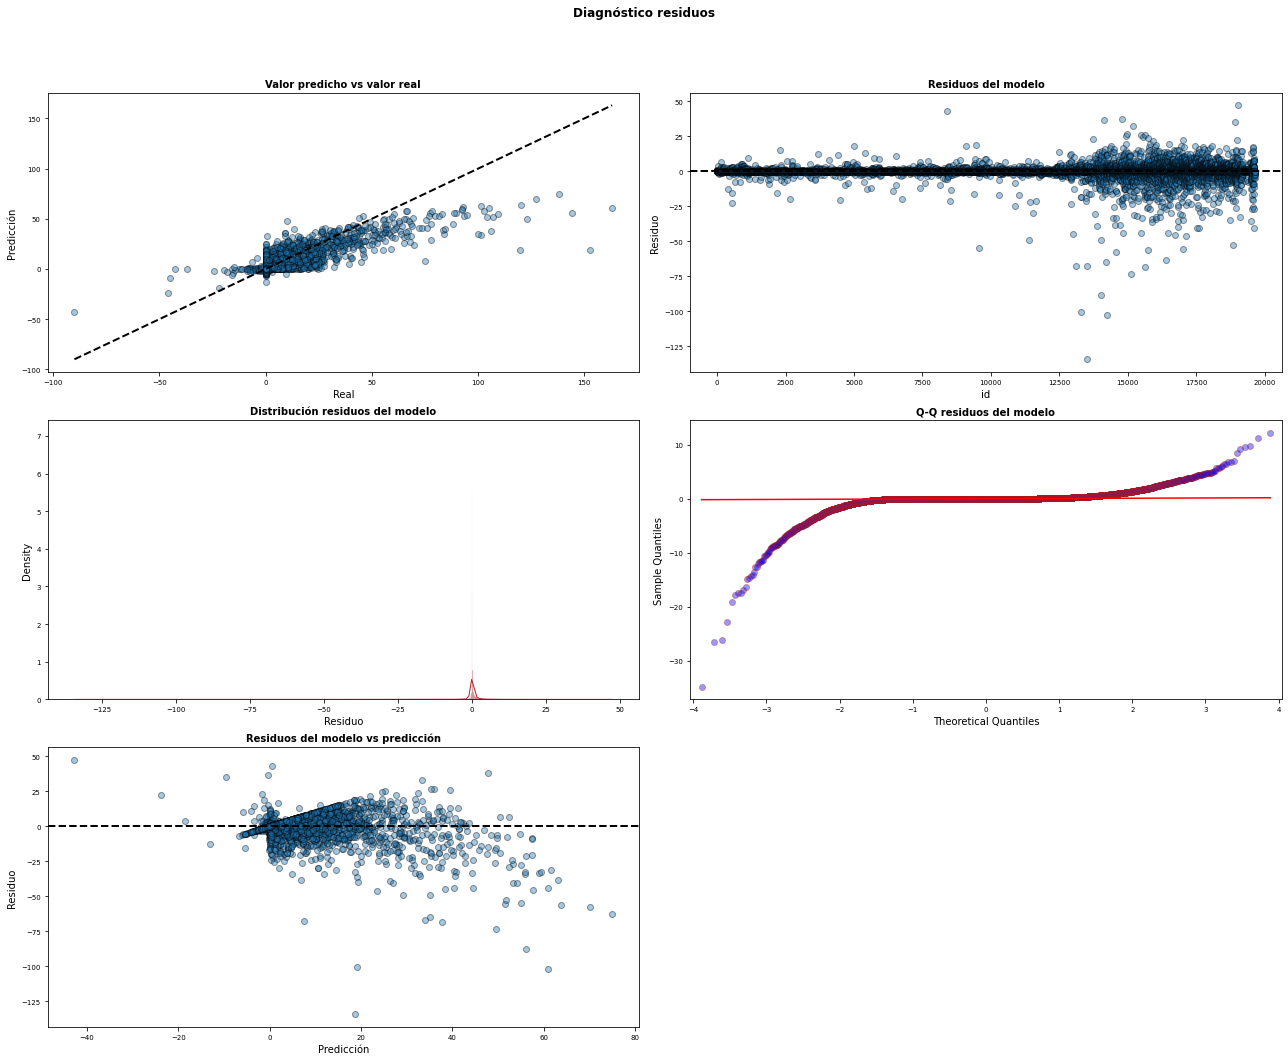

In [ ]:
# Diagnostico de residuos de train
diag_residuos (df_pred_train.delta_WHP, df_pred_train.delta_WHP_pred)

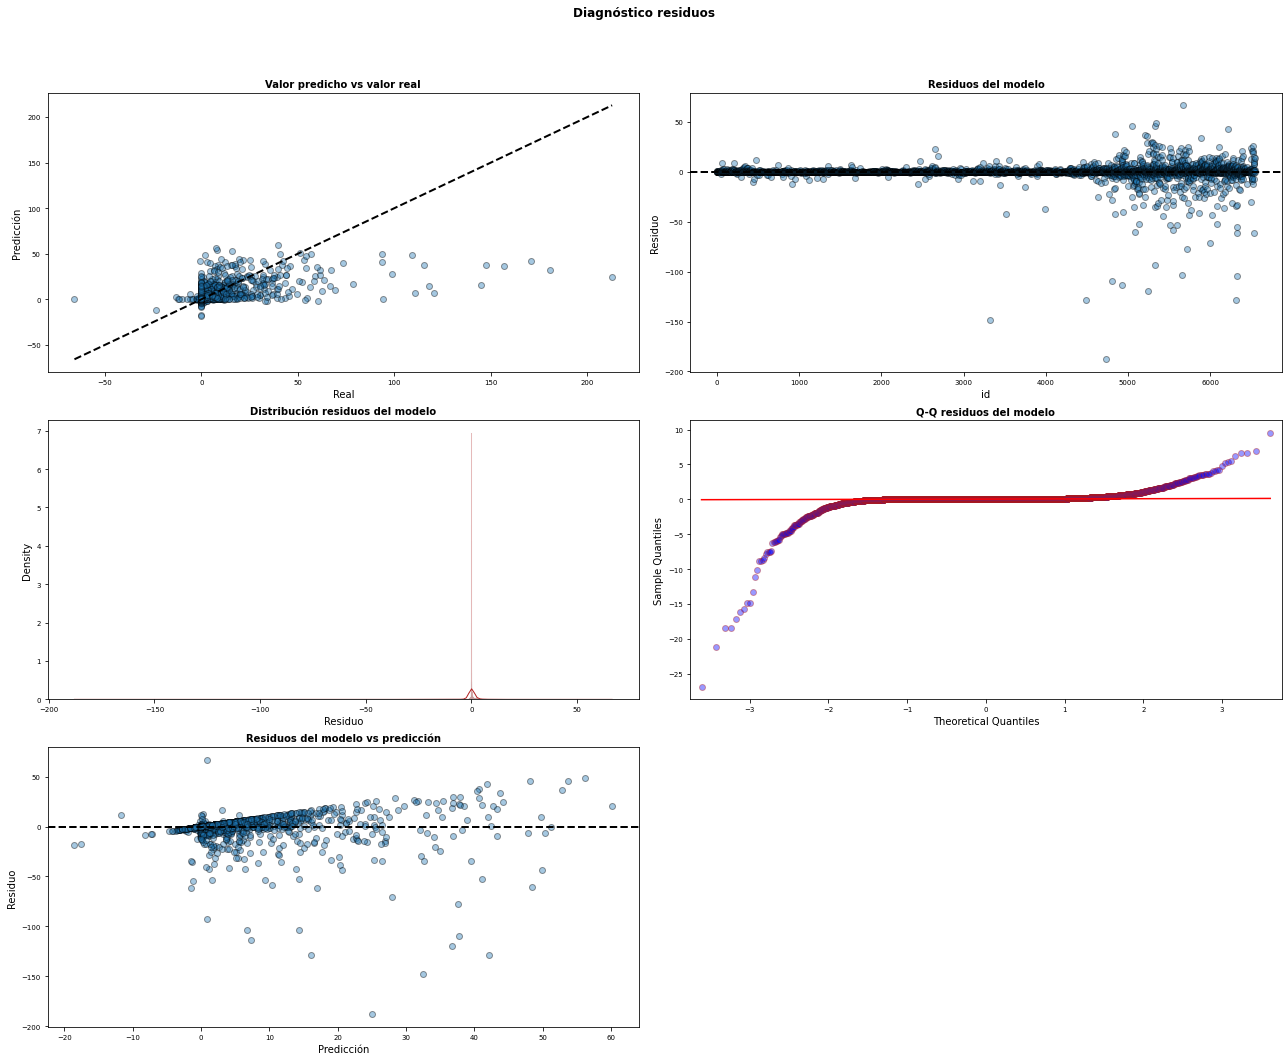

In [ ]:
# Diagnostico de residuos de test
diag_residuos (df_pred_test.delta_WHP, df_pred_test.delta_WHP_pred)